## Example: basic vectorization and distributed computation

Loops are fast, as fast as your CPU, but they often only use a little part of the available bandwith/flow rate so to speak. 

Vectorized approaches try to frame problems so the number of calculations which can be done in one iteration aim to be as large, or larger than the capacity of the CPU.

Distributed computing (clusters) allows you to use multiple cores, possibly other machines and CGUs.

Here is the difference in performance for a popular question: how to calculate pi using a monte carlo simulation. 

The algorithm is easy to understand, and inefficient: a perfect example to demonstrate the difference in computing power.

In [1]:
import numpy as np

from dask import delayed
from dask.distributed import Client, LocalCluster
from time import sleep

# graphviz for visuals 
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Non vectorized approach

The default python sum uses iteration = a loop.

In [2]:
def pi_1(accuracy):
    v = np.random.rand(accuracy)**2 + np.random.rand(accuracy)**2 < 1
    return 4*sum(v) / accuracy

In [3]:
%timeit -n1 pi_1(10**5)
pi_1(10**5)

1 loop, best of 3: 1.11 s per loop


3.14956

Okak, it gets an answer.

### Numpy vectorized

- Try to avoid any loop where possible. 
- Rephrase command and control statements (if else) as matrix dot multiplications, additions, ...

In this case replacing the sum by np.sum suffices.

In [4]:
def pi_2(accuracy):
    c = np.sum(np.random.rand(accuracy)**2 +
               np.random.rand(accuracy)**2
               < 1)
    return 4*c / accuracy

%timeit -n1 pi_2(10**5)
%timeit -n1 pi_2(10**7)
pi_2(10**7)

1 loop, best of 3: 8.7 ms per loop
1 loop, best of 3: 937 ms per loop


3.1424264

Thats about a **100x** as fast. At this point the generation of the random arrays has become the most costly part of the calculation.

### Using Dask with a scheduler, no clients.

After vectorization, you're all set and ready to go to use more cores, GPUs, [machines](https://www.raspberrypi.org/products/), ... or some cloud. These gains are smaller, and more costly.

In [5]:
def pi_3(accuracy,n):
    q = accuracy//n
    graph = average([step(accuracy//n) for _ in range(n)],n)
    return graph.compute()

@delayed
def step(accuracy):
    c = np.sum(np.random.rand(accuracy)**2+
               np.random.rand(accuracy)**2
               < 1.0)
    return 4*c / accuracy

@delayed
def average(args,n):
    return sum(args)/n

problem_size = 10**7
cores = 4

print('Same as before')
%timeit -n1 pi_2(problem_size)
print('\nSame as before, with overhead')
%timeit -n1 pi_3(problem_size,1)
print('\nSame as before, using the default scheduler')
%timeit -n1 pi_3(problem_size,cores)

Same as before
1 loop, best of 3: 937 ms per loop

Same as before, with overhead
1 loop, best of 3: 970 ms per loop

Same as before, using the default scheduler
1 loop, best of 3: 660 ms per loop


Still no C, but getting more decent.

### Using a scheduler and dedicated workers

- Using a cluster scheduler incurs some cost, try to use tasks > 100ms.
- Launching clients takes some time. 
 There is some overhead, but in many cases it's easier to just leave them running.
- Many tasks can be linked to a cluster.
- Should be faster using unix forks.

In [6]:
%%time

cluster = LocalCluster(n_workers=4,threads_per_worker=4)
client = Client(cluster)

Wall time: 21.4 s


In [7]:
client

<Client: scheduler='tcp://127.0.0.1:57446' processes=4 cores=16>

In [8]:
%timeit -n10 pi_3(problem_size-1,cores)

10 loops, best of 3: 554 ms per loop


Note there is only a limited gain compared to the vectorized approach.

### Just a bit larger

In [9]:
problem_size = 2*10**8
cores = 4

%timeit -n1 -r1 pi_2(problem_size)
%timeit -n1 -r1 pi_3(problem_size,1)
%timeit -n1 -r1 pi_3(problem_size,cores)
%timeit -n1 -r1 pi_3(problem_size,cores**2)

1 loop, best of 1: 59.3 s per loop
1 loop, best of 1: 23.4 s per loop
1 loop, best of 1: 14.9 s per loop
1 loop, best of 1: 9.85 s per loop


Well, my CPU should have been wide awake at this point. Still a **3x** increase compared to vanilla numpy on my humble machine.

### Visualize

You can see what is happeing: using the delayed doesn't compute, but creates a task plan. The compute() call gives this structure to the scheduler.

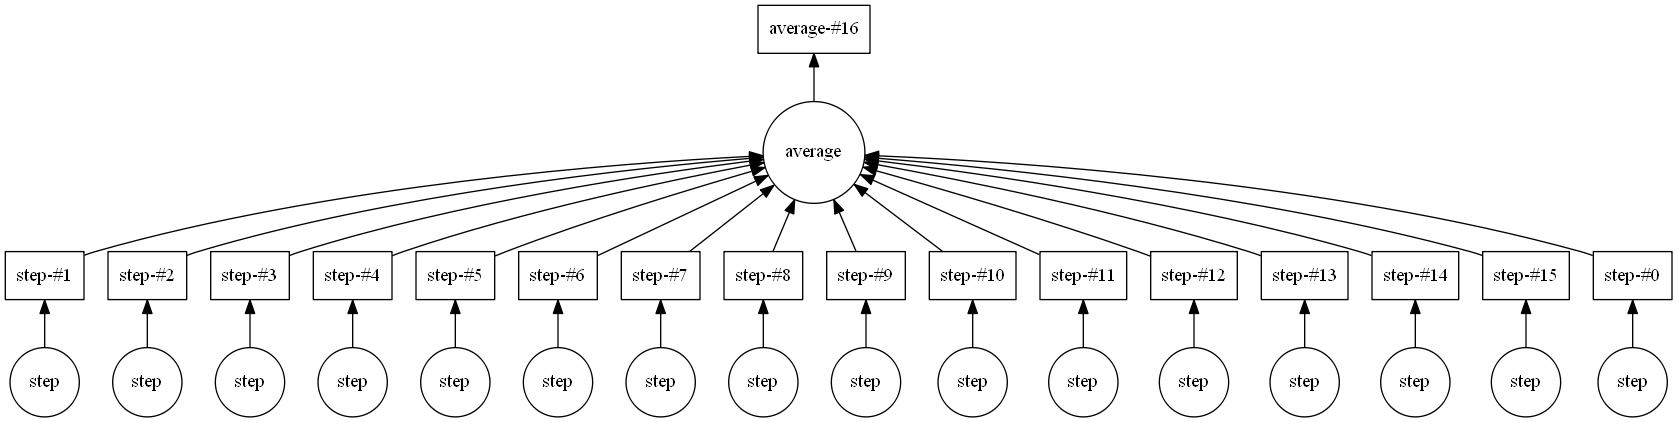

In [10]:
def pi_3(accuracy,n):
    q = accuracy//n
    graph = average([step(accuracy//n) for _ in range(n)],n)
    return graph

graph = pi_3(problem_size,cores**2)
graph.visualize()

In [11]:
graph.compute()

3.1415714799999996

Well, i hope you've learned some things today, i did. 

- no GIL helps, but it's a poot substiture for [a better algorithm](https://stackoverflow.com/questions/19/what-is-the-fastest-way-to-get-the-value-of-%CF%80).
- Vectorization is genuinely "awesome", and a good first step toward distributed computations.
- Distributed computations can only yield a few power of 2.

Inspired by [this reddit post](https://old.reddit.com/r/learnpython/comments/ahy84c/can_i_make_estimating_pi_with_the_monte_carlo/): Thanks u\ikar1234.

### Bonus unsing Numba

Thanks u\DiogenicOrder

Boilerplate demo from site

In [38]:
from numba import jit
import random

@jit(nopython=True)
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [39]:
monte_carlo_pi(2*10**8)

3.1417957

In [36]:
%timeit -n1 -r1 monte_carlo_pi(problem_size)

1 loop, best of 1: 8.13 s per loop


I notice only one core is used, meaning some dask could be used?